In [19]:
# Python program to create 
# Image Classifier using CNN 

# Importing the required libraries 
import cv2 
import os 
import numpy as np 
from random import shuffle 
from tqdm import tqdm 

'''Setting up the env'''

TRAIN_DIR = '/home/quixom30/Projects/Deep_Learning/mohanlal-mammooty-images'
TEST_DIR = '/home/quixom30/Projects/Deep_Learning/dogs-vs-cats/my_test1'
IMG_SIZE = 50
LR = 1e-3


'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic') 

'''Labelling the dataset'''
def label_img(img): 
	word_label = img.split('.')[-3] 
	# DIY One hot encoder 
	if word_label == 'mohanlal': return [0, 1] 
	elif word_label == 'mammooty': return [1, 0] 

'''Creating the training data'''
def create_train_data(): 
	# Creating an empty list where we should store the training data 
	# after a little preprocessing of the data 
	training_data = [] 

	# tqdm is only used for interactive loading 
	# loading the training data 
	for img in tqdm(os.listdir(TRAIN_DIR)): 

		# labeling the images 
		label = label_img(img) 

		path = os.path.join(TRAIN_DIR, img) 

		# loading the image from the path and then converting them into 
		# greyscale for easier covnet prob 
		img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 

		# resizing the image for processing them in the covnet 
		img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

		# final step-forming the training data list with numpy array of the images 
		training_data.append([np.array(img), np.array(label)]) 

	# shuffling of the training data to preserve the random state of our data 
	shuffle(training_data) 

	# saving our trained data for further uses if required 
	np.save('train_data.npy', training_data) 
	return training_data 

'''Processing the given test data'''
# Almost same as processing the training data but 
# we dont have to label it. 
def process_test_data(): 
	testing_data = [] 
	for img in tqdm(os.listdir(TEST_DIR)): 
		path = os.path.join(TEST_DIR, img) 
		img_num = img.split('.')[0] 
		img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
		img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
		testing_data.append([np.array(img), img_num]) 
		
	shuffle(testing_data) 
	np.save('test_data.npy', testing_data) 
	return testing_data 

'''Running the training and the testing in the dataset for our model'''


'Running the training and the testing in the dataset for our model'

In [20]:
train_data = create_train_data() 
print(type(train_data))

100%|██████████| 5058/5058 [00:20<00:00, 241.31it/s]


<class 'list'>


In [21]:
# train_data = np.load('train_data.npy') 
# test_data = np.load('test_data.npy') 
'''Creating the neural network using tensorflow'''
# Importing the required libraries 
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 

import tensorflow as tf 
tf.reset_default_graph() 
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 

convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 

convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 

convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, 
	loss ='categorical_crossentropy', name ='targets') 

model = tflearn.DNN(convnet, tensorboard_dir ='log') 

# Splitting the testing data and training data 
train = train_data[:-500] 
test = train_data[-500:] 

'''Setting up the features and lables'''
# X-Features & Y-Labels 

X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
Y = [i[1] for i in train] 
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
test_y = [i[1] for i in test] 

'''Fitting the data into our model'''
# epoch = 5 taken 
model.fit(
    {'input': X},
    {'targets': Y},
    n_epoch = 10, 
    validation_set =(
        {'input': test_x},
        {'targets': test_y}
    ), 
    snapshot_step = 500,
    show_metric = True,
    run_id = MODEL_NAME
) 
model.save(MODEL_NAME) 

'''Testing the data'''


Training Step: 719  | total loss: 0.36039 | time: 6.231s
| Adam | epoch: 010 | loss: 0.36039 - acc: 0.8580 -- iter: 4544/4558
Training Step: 720  | total loss: 0.34840 | time: 7.328s
| Adam | epoch: 010 | loss: 0.34840 - acc: 0.8628 | val_loss: 0.67357 - val_acc: 0.7020 -- iter: 4558/4558
--
INFO:tensorflow:/home/quixom30/Projects/Deep_Learning/dogsvscats-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


'Testing the data'

In [22]:
test_data = process_test_data() 
# print(test_data)
# print(train_data[:10])

100%|██████████| 6/6 [00:00<00:00, 1042.93it/s]


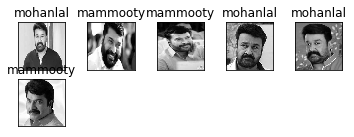

In [23]:
import matplotlib.pyplot as plt 

test_data = np.load('test_data.npy', allow_pickle=True) 

fig = plt.figure() 

for num, data in enumerate(test_data[:20]): 
	# cat: [1, 0] 
	# dog: [0, 1] 
	
	img_num = data[1] 
	img_data = data[0] 
	
	y = fig.add_subplot(4, 5, num + 1) 
	orig = img_data 
	data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 

	# model_out = model.predict([data])[0] 
	model_out = model.predict([data])[0] 
	
	if np.argmax(model_out) == 1: str_label ='mohanlal'
	else: str_label ='mammooty'
		
	y.imshow(orig, cmap ='gray') 
	plt.title(str_label) 
	y.axes.get_xaxis().set_visible(False) 
	y.axes.get_yaxis().set_visible(False) 
plt.show() 

In [ ]:
print('type :--- ', type(X), type(Y), type(test_x), type(test_y), type(train), type(test), type(MODEL_NAME))